In [1]:
pip install fastf1

In [2]:
import fastf1
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [3]:
import os
os.makedirs("f1_cache", exist_ok=True)
fastf1.Cache.enable_cache("f1_cache")


In [4]:
# load the 2024 Austrian session data
session_2024 = fastf1.get_session(2024, 11, "R")
session_2024.load()
laps_2024 = session_2024.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
laps_2024.dropna(inplace=True)


core           INFO 	Loading data for Austrian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Austrian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:52:13.256' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_a

In [5]:
# convert lap and sector times to seconds
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_2024[f"{col} (s)"] = laps_2024[col].dt.total_seconds()

In [6]:
# aggregate sector times by driver
sector_times_2024 = laps_2024.groupby("Driver").agg({
    "Sector1Time (s)": "mean",
    "Sector2Time (s)": "mean",
    "Sector3Time (s)": "mean"
}).reset_index()

sector_times_2024["TotalSectorTime (s)"] = (
    sector_times_2024["Sector1Time (s)"] +
    sector_times_2024["Sector2Time (s)"] +
    sector_times_2024["Sector3Time (s)"]
)

In [7]:
clean_air_race_pace = {
    "VER": 93.191067, "HAM": 94.020622, "LEC": 93.418667, "NOR": 93.428600, "ALO": 94.784333,
    "PIA": 93.232111, "RUS": 93.833378, "SAI": 94.497444, "STR": 95.318250, "HUL": 95.345455,
    "OCO": 95.682128
}

In [8]:
# quali data from Barcelona GP
qualifying_2025 = pd.DataFrame({
    "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO",
               "HAM", "STR", "GAS", "ALO", "HUL"],
    "QualifyingTime (s)": [
        64.929,  # VER (1:11.848)
        63.971,  # NOR (1:11.755)
        64.554,  # PIA (1:11.546)
        64.763,  # RUS (1:11.848)
        65.582,  # SAI (1:13.203)
        65.205,  # ALB (1:12.641)
        64.492,  # LEC (1:12.131)
        65.364,  # OCO (1:13.201)
        64.582,  # HAM (1:12.045)
        65.329,  # STR (1:13.058)
        65.649,  # GAS (1:12.199)
        65.128,  # ALO (1:12.284)
        65.606   # HUL (1:13.190)
    ]
})

qualifying_2025["CleanAirRacePace (s)"] = qualifying_2025["Driver"].map(clean_air_race_pace)

driver_to_team = {
    "VER": "Red Bull", "NOR": "McLaren", "PIA": "McLaren", "LEC": "Ferrari", "RUS": "Mercedes",
    "HAM": "Ferrari", "GAS": "Alpine", "ALO": "Aston Martin", "TSU": "Red Bull",
    "SAI": "Williams", "HUL": "Kick Sauber", "OCO": "Alpine", "STR": "Aston Martin"
}

# Add the Team column to qualifying_2025
qualifying_2025["Team"] = qualifying_2025["Driver"].map(driver_to_team)


# Dynamically calculate team performance boost
team_avg_pace = qualifying_2025.groupby("Team")["CleanAirRacePace (s)"].mean()
max_pace = team_avg_pace.min()  # Best team has lowest time

team_boost = (max_pace / team_avg_pace).to_dict()
qualifying_2025["TeamBoost"] = qualifying_2025["Team"].map(team_boost)


# Final scoring logic
qualifying_2025["FinalScore"] = (
    qualifying_2025["CleanAirRacePace (s)"] * qualifying_2025["TeamBoost"]
)
qualifying_2025["PredictionRank"] = qualifying_2025["FinalScore"].rank()


In [9]:
# get weather data for italy
API_KEY = "e649b58b58905cd519de6ca5745071b4"
#weather_url = f"http://api.openweathermap.org/data/2.5/forecast?lat=43.7384&lon=7.4246&appid={API_KEY}&units=metric"
#response = requests.get(weather_url)
#weather_data = response.json()
#forecast_time = "2025-05-25 13:00:00"  # 15:00 CEST local time
#forecast_data = next((f for f in weather_data["list"] if f["dt_txt"] == forecast_time), None)

#rain_probability = forecast_data["pop"] if forecast_data else 0
#temperature = forecast_data["main"]["temp"] if forecast_data else 20

In [10]:
import requests, json

url = f"http://api.openweathermap.org/data/2.5/forecast?lat=47.2196&lon=14.7648&appid={API_KEY}&units=metric"
res = requests.get(url)
print(json.dumps(res.json(), indent=2))


{
  "cod": "200",
  "message": 0,
  "cnt": 40,
  "list": [
    {
      "dt": 1751252400,
      "main": {
        "temp": 18.12,
        "feels_like": 18.13,
        "temp_min": 18.12,
        "temp_max": 18.12,
        "pressure": 1022,
        "sea_level": 1022,
        "grnd_level": 894,
        "humidity": 82,
        "temp_kf": 0
      },
      "weather": [
        {
          "id": 804,
          "main": "Clouds",
          "description": "overcast clouds",
          "icon": "04n"
        }
      ],
      "clouds": {
        "all": 100
      },
      "wind": {
        "speed": 1.63,
        "deg": 304,
        "gust": 1.59
      },
      "visibility": 10000,
      "pop": 0,
      "sys": {
        "pod": "n"
      },
      "dt_txt": "2025-06-30 03:00:00"
    },
    {
      "dt": 1751263200,
      "main": {
        "temp": 19.24,
        "feels_like": 19.23,
        "temp_min": 19.24,
        "temp_max": 21.48,
        "pressure": 1022,
        "sea_level": 1022,
        "grnd_level

In [11]:
response = requests.get(url)
weather_data = response.json()

In [12]:
from datetime import datetime

# Target date you want to match (e.g., race time)

target_time = datetime(2025, 6, 29, 15, 0)  # 29th June, 3PM CEST

# Convert and find closest available forecast time
forecast_data = min(
    weather_data["list"],
    key=lambda f: abs(datetime.strptime(f["dt_txt"], "%Y-%m-%d %H:%M:%S") - target_time)
)

rain_probability = forecast_data["pop"]
temperature = forecast_data["main"]["temp"]

print("Forecast time used:", forecast_data["dt_txt"])
print("Rain probability:", rain_probability)
print("Temperature:", temperature)


Forecast time used: 2025-06-30 03:00:00
Rain probability: 0
Temperature: 18.12


In [13]:
response = requests.get(url)
weather_data = response.json()


In [14]:
# adjust qualifying time based on weather conditions
if rain_probability >= 0.75:
    qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"] * qualifying_2025["WetPerformanceFactor"]
else:
    qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"]


In [15]:
# add constructor's data
team_points = {
    "McLaren": 374, "Mercedes": 199, "Red Bull": 162, "Williams": 55, "Ferrari": 183,
    "Haas": 28, "Aston Martin": 22, "Kick Sauber": 20, "Racing Bulls": 28, "Alpine": 11
}
max_points = max(team_points.values())
team_performance_score = {team: points / max_points for team, points in team_points.items()}

driver_to_team = {
    "VER": "Red Bull", "NOR": "McLaren", "PIA": "McLaren", "LEC": "Ferrari", "RUS": "Mercedes",
    "HAM": "Ferrari", "GAS": "Alpine", "ALO": "Aston Martin", "TSU": "Red Bull",
    "SAI": "Williams", "HUL": "Kick Sauber", "OCO": "Alpine", "STR": "Aston Martin"
}

qualifying_2025["Team"] = qualifying_2025["Driver"].map(driver_to_team)
qualifying_2025["TeamPerformanceScore"] = qualifying_2025["Team"].map(team_performance_score)

In [16]:
driver_points = {
    "PIA": 198,  # Oscar Piastri
    "NOR": 176,  # Lando Norris
    "VER": 155,  # Max Verstappen
    "RUS": 136,  # George Russell
    "LEC": 104,  # Charles Leclerc
    "HAM": 79,   # Lewis Hamilton
    "ALB": 42,   # Alexander Albon
    "OCO": 22,   # Esteban Ocon
    "HUL": 20,   # Nico Hulkenberg
    "STR": 14,   # Lance Stroll
    "SAI": 13,   # Carlos Sainz
    "GAS": 11,   # Pierre Gasly
    "ALO": 8,    # Fernando Alonso
}
qualifying_2025["DriverPoints"] = qualifying_2025["Driver"].map(driver_points)


In [17]:
#Approximate team pace based on recent Quali or Clean Air Race Pace
team_avg_pace = qualifying_2025.groupby("Team")["CleanAirRacePace (s)"].mean()
max_pace = team_avg_pace.min()  # Best team = lowest time

team_boost = (max_pace / team_avg_pace).to_dict()
qualifying_2025["TeamBoost"] = qualifying_2025["Team"].map(team_boost)

In [18]:
## Tyre Strategy
# Step 1: Define degradation rates (seconds per lap)
tyre_degradation_rates = {'soft': 0.08, 'medium': 0.03, 'hard': 0.01}

# Step 2: Use YOUR tyre strategy data
stints_data = [
    # Red Bull
    {'Driver': 'VER', 'TyreCompound': 'medium', 'StartLap': 1,  'EndLap': 23},
    {'Driver': 'VER', 'TyreCompound': 'hard',   'StartLap': 24, 'EndLap': 51},
    {'Driver': 'VER', 'TyreCompound': 'medium', 'StartLap': 52, 'EndLap': 69},

    # McLaren
    {'Driver': 'PIA', 'TyreCompound': 'medium', 'StartLap': 1,  'EndLap': 22},
    {'Driver': 'PIA', 'TyreCompound': 'hard',   'StartLap': 23, 'EndLap': 50},
    {'Driver': 'PIA', 'TyreCompound': 'medium', 'StartLap': 51, 'EndLap': 71},

    {'Driver': 'NOR', 'TyreCompound': 'medium', 'StartLap': 1,  'EndLap': 19},
    {'Driver': 'NOR', 'TyreCompound': 'hard',   'StartLap': 20, 'EndLap': 49},
    {'Driver': 'NOR', 'TyreCompound': 'hard',   'StartLap': 50, 'EndLap': 64},

    # Ferrari
    {'Driver': 'LEC', 'TyreCompound': 'medium', 'StartLap': 1,  'EndLap': 1},
    {'Driver': 'LEC', 'TyreCompound': 'hard',   'StartLap': 2,  'EndLap': 23},
    {'Driver': 'LEC', 'TyreCompound': 'medium', 'StartLap': 24, 'EndLap': 48},
    {'Driver': 'LEC', 'TyreCompound': 'medium', 'StartLap': 49, 'EndLap': 71},

    {'Driver': 'HAM', 'TyreCompound': 'medium', 'StartLap': 1,  'EndLap': 21},
    {'Driver': 'HAM', 'TyreCompound': 'hard',   'StartLap': 22, 'EndLap': 50},
    {'Driver': 'HAM', 'TyreCompound': 'medium', 'StartLap': 51, 'EndLap': 71},

    # Mercedes
    {'Driver': 'RUS', 'TyreCompound': 'medium', 'StartLap': 1,  'EndLap': 22},
    {'Driver': 'RUS', 'TyreCompound': 'medium', 'StartLap': 23, 'EndLap': 49},
    {'Driver': 'RUS', 'TyreCompound': 'hard',   'StartLap': 50, 'EndLap': 71},

    # Haas
    {'Driver': 'HUL', 'TyreCompound': 'medium', 'StartLap': 1,  'EndLap': 22},
    {'Driver': 'HUL', 'TyreCompound': 'hard',   'StartLap': 23, 'EndLap': 50},
    {'Driver': 'HUL', 'TyreCompound': 'hard',   'StartLap': 51, 'EndLap': 71},

    # Alpine
    {'Driver': 'GAS', 'TyreCompound': 'medium', 'StartLap': 1,  'EndLap': 21},
    {'Driver': 'GAS', 'TyreCompound': 'hard',   'StartLap': 22, 'EndLap': 50},
    {'Driver': 'GAS', 'TyreCompound': 'medium', 'StartLap': 51, 'EndLap': 71},

    {'Driver': 'OCO', 'TyreCompound': 'medium', 'StartLap': 1,  'EndLap': 21},
    {'Driver': 'OCO', 'TyreCompound': 'hard',   'StartLap': 22, 'EndLap': 50},
    {'Driver': 'OCO', 'TyreCompound': 'medium', 'StartLap': 51, 'EndLap': 71},

    # Aston Martin
    {'Driver': 'ALO', 'TyreCompound': 'medium', 'StartLap': 1,  'EndLap': 21},
    {'Driver': 'ALO', 'TyreCompound': 'hard',   'StartLap': 22, 'EndLap': 50},
    {'Driver': 'ALO', 'TyreCompound': 'soft',   'StartLap': 51, 'EndLap': 70},

    {'Driver': 'STR', 'TyreCompound': 'medium', 'StartLap': 1,  'EndLap': 20},
    {'Driver': 'STR', 'TyreCompound': 'hard',   'StartLap': 21, 'EndLap': 49},
    {'Driver': 'STR', 'TyreCompound': 'medium', 'StartLap': 50, 'EndLap': 70},

    # Williams
    {'Driver': 'ALB', 'TyreCompound': 'medium', 'StartLap': 1,  'EndLap': 21},
    {'Driver': 'ALB', 'TyreCompound': 'hard',   'StartLap': 22, 'EndLap': 50},
    {'Driver': 'ALB', 'TyreCompound': 'hard',   'StartLap': 51, 'EndLap': 70},

    {'Driver': 'SAI', 'TyreCompound': 'medium', 'StartLap': 1,  'EndLap': 21},
    {'Driver': 'SAI', 'TyreCompound': 'hard',   'StartLap': 22, 'EndLap': 50},
    {'Driver': 'SAI', 'TyreCompound': 'medium', 'StartLap': 51, 'EndLap': 71},
]

# Step 3: Calculate degradation
import pandas as pd

# Convert to DataFrame
stints_df = pd.DataFrame(stints_data)

# Calculate stint length and degradation
stints_df['StintLength'] = stints_df['EndLap'] - stints_df['StartLap'] + 1
stints_df['StintDegradation'] = stints_df.apply(
    lambda row: tyre_degradation_rates[row['TyreCompound'].lower()] * row['StintLength'],
    axis=1
)

# Sum degradation per driver
driver_degradation = stints_df.groupby('Driver')['StintDegradation'].sum().reset_index()
driver_degradation.rename(columns={'StintDegradation': 'TotalDegradation'}, inplace=True)




In [19]:
# merge qualifying and sector times data
merged_data = qualifying_2025.merge(sector_times_2024[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
merged_data["RainProbability"] = rain_probability
merged_data["Temperature"] = temperature
merged_data["QualifyingTime"] = merged_data["QualifyingTime"]

# After computing team_boost dictionary
merged_data["TeamBoost"] = merged_data["Team"].map(team_boost)

#valid_drivers = merged_data["Driver"].isin(laps_2024["Driver"].unique())
#merged_data = merged_data[valid_drivers]

merged_data["QualifyingTimeMinusCleanAirPace"] = (
    merged_data["QualifyingTime"] - merged_data["CleanAirRacePace (s)"]
)


# Compute standard deviation of lap times for each driver
driver_consistency = laps_2024.groupby("Driver")["LapTime (s)"].std()

# Map it to merged_data
merged_data["DriverConsistency"] = merged_data["Driver"].map(driver_consistency)

merged_data["DriverPoints"] = merged_data["Driver"].map(driver_points)

# Step 4: Merge with main data
# Now merge degradation
merged_data = merged_data.merge(driver_degradation, on='Driver', how='left')




In [20]:
# define features (X) and target (y)
X = merged_data[[
    "QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore",
    "CleanAirRacePace (s)", "QualifyingTimeMinusCleanAirPace", "DriverConsistency", "TeamBoost", "DriverPoints"
]]
y = laps_2024.groupby("Driver")["LapTime (s)"].mean().reindex(merged_data["Driver"])

In [21]:
# impute missing values for features
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=37)


In [22]:
# train gradient boosting model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.2, max_depth=3, random_state=37)
model.fit(X_train, y_train)
merged_data["PredictedRaceTime (s)"] = model.predict(X_imputed)


In [23]:
# sort the results to find the predicted winner
final_results = merged_data.sort_values("PredictedRaceTime (s)")
print("\n🏁 Predicted 2025 Austrian GP Winner 🏁\n")
print(final_results[["Driver", "PredictedRaceTime (s)"]])
y_pred = model.predict(X_test)
print(f"Model Error (MAE): {mean_absolute_error(y_test, y_pred):.2f} seconds")


🏁 Predicted 2025 Austrian GP Winner 🏁

   Driver  PredictedRaceTime (s)
2     PIA              71.253629
3     RUS              71.262814
8     HAM              71.587143
0     VER              71.685729
1     NOR              71.709254
12    HUL              71.978086
10    GAS              72.077929
4     SAI              72.092688
6     LEC              72.110986
9     STR              72.250362
7     OCO              72.279196
5     ALB              72.364594
11    ALO              72.906522
Model Error (MAE): 0.32 seconds


In [24]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate and print MAE
test_mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {test_mae:.2f} seconds")


Test MAE: 0.32 seconds


In [25]:
# Plot feature importances
feature_importance = model.feature_importances_
features = X.columns

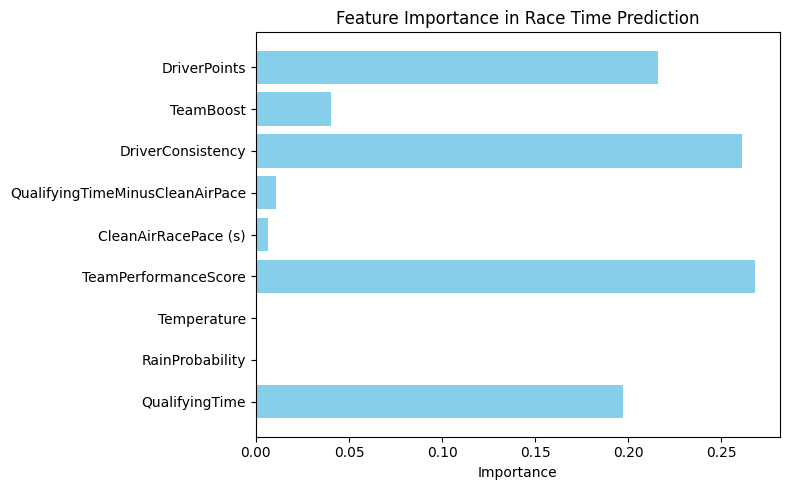

In [26]:

plt.figure(figsize=(8,5))
plt.barh(features, feature_importance, color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance in Race Time Prediction")
plt.tight_layout()
plt.show()

In [27]:
# sort results and get top 3
final_results = merged_data.sort_values("PredictedRaceTime (s)").reset_index(drop=True)
podium = final_results.loc[:2, ["Driver", "PredictedRaceTime (s)"]]

print("\n🏆 Predicted in the Top 3 🏆")
print(f"🥇 P1: {podium.iloc[0]['Driver']}")
print(f"🥈 P2: {podium.iloc[1]['Driver']}")
print(f"🥉 P3: {podium.iloc[2]['Driver']}")


🏆 Predicted in the Top 3 🏆
🥇 P1: PIA
🥈 P2: RUS
🥉 P3: HAM


In [28]:
# KNeighborsRegressor

In [29]:
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Drop non-numeric or irrelevant columns
X = merged_data.drop(columns=["Driver", "Team", "PredictedRaceTime (s)"], errors='ignore')
y = merged_data["PredictedRaceTime (s)"]

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [30]:
# KNN Model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict and evaluate
y_pred = knn.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Model Error (MAE): {mae:.2f} seconds")

# Predict full set
merged_data["PredictedRaceTime (s)"] = knn.predict(X_scaled)

# 1. Train the model on training data
knn.fit(X_train, y_train)

# 2. Predict on test data
y_pred = knn.predict(X_test)

# 3. Calculate MAE on test data
mae = mean_absolute_error(y_test, y_pred)
print(f"Test Model Error (MAE): {mae:.2f} seconds")


Model Error (MAE): 0.29 seconds
Test Model Error (MAE): 0.29 seconds


In [31]:
# Output predictions
print(merged_data[["Driver", "PredictedRaceTime (s)"]].sort_values(by="PredictedRaceTime (s)"))

   Driver  PredictedRaceTime (s)
1     NOR              71.584765
2     PIA              71.584765
3     RUS              71.712174
0     VER              71.715833
8     HAM              71.803299
6     LEC              71.816942
4     SAI              71.955222
7     OCO              72.158498
12    HUL              72.158498
9     STR              72.158498
5     ALB              72.158498
10    GAS              72.158498
11    ALO              72.162158


In [32]:
# Sort by predicted race time from the KNN model
knn_results = merged_data.sort_values("PredictedRaceTime (s)").reset_index(drop=True)

# Get top 3 drivers
podium_knn = knn_results.loc[:2, ["Driver", "PredictedRaceTime (s)"]]

# Print formatted podium
print("\n🏆 KNN Model: Predicted Top 3 🏆")
print(f"🥇 P1: {podium_knn.iloc[0]['Driver']}")
print(f"🥈 P2: {podium_knn.iloc[1]['Driver']}")
print(f"🥉 P3: {podium_knn.iloc[2]['Driver']}")



🏆 KNN Model: Predicted Top 3 🏆
🥇 P1: NOR
🥈 P2: PIA
🥉 P3: RUS


In [33]:
#SVR

In [34]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# Feature scaling (SVR benefits from scaled input)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train-test split (already defined above)
X_train_svr, X_test_svr, y_train_svr, y_test_svr = train_test_split(X_scaled, y, test_size=0.3, random_state=999)

# Define and train the SVR model
svr_model = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.05)
svr_model.fit(X_train_svr, y_train_svr)

# Predict
y_pred_svr = svr_model.predict(X_test_svr)

# Evaluate
mae_svr = mean_absolute_error(y_test_svr, y_pred_svr)
print(f"\n📏 SVR Model Error (MAE): {mae_svr:.2f} seconds")

# Predict full race time for all drivers
merged_data["SVR_PredictedRaceTime (s)"] = svr_model.predict(X_scaled)

# Sort for results
svr_results = merged_data.sort_values("SVR_PredictedRaceTime (s)").reset_index(drop=True)
podium_svr = svr_results.loc[:2, ["Driver", "SVR_PredictedRaceTime (s)"]]

print("\n🏆 SVR Model: Predicted Top 3 🏆")
print(f"🥇 P1: {podium_svr.iloc[0]['Driver']}")
print(f"🥈 P2: {podium_svr.iloc[1]['Driver']}")
print(f"🥉 P3: {podium_svr.iloc[2]['Driver']}")



📏 SVR Model Error (MAE): 0.46 seconds

🏆 SVR Model: Predicted Top 3 🏆
🥇 P1: RUS
🥈 P2: PIA
🥉 P3: HAM
